In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter

In [11]:
import kagglehub
path = kagglehub.dataset_download("amerzishminha/forest-fire-smoke-and-non-fire-image-dataset")

Using Colab cache for faster access to the 'forest-fire-smoke-and-non-fire-image-dataset' dataset.


In [15]:
import os
import shutil

src = "/kaggle/input/forest-fire-smoke-and-non-fire-image-dataset/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET"

os.makedirs("images", exist_ok=True)

for split in ["train", "test"]:
    shutil.copytree(
        os.path.join(src, split),
        os.path.join("images", split)
    )

EDA

In [20]:
import os
import shutil
import random

def copy_n_files(src_dir, dst_dir, n=4000):
    os.makedirs(dst_dir, exist_ok=True)
    classes = [d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]

    for cls in classes:
        src_path = os.path.join(src_dir, cls)
        dst_path = os.path.join(dst_dir, cls)
        os.makedirs(dst_path, exist_ok=True)

        files = os.listdir(src_path)
        if len(files) < n:
            raise ValueError(f"Not enough files in class {cls}")

        selected = random.sample(files, n)
        for f in selected:
            shutil.copy2(os.path.join(src_path, f), os.path.join(dst_path, f))

        print(f"{cls}: copied {n} files")

copy_n_files("images/train", "images/train_small", 4000)

fire: copied 4000 files
Smoke: copied 4000 files
non fire: copied 4000 files


In [21]:
train_dir = "images/train_small"

raw_train_dataset = datasets.ImageFolder(root=train_dir)

print("Train classes:", raw_train_dataset.classes)
print("Train images:", len(raw_train_dataset))

Train classes: ['Smoke', 'fire', 'non fire']
Train images: 12000


In [22]:
test_dir = "images/test"

test_dataset = datasets.ImageFolder(root=test_dir)

print("Test classes:", test_dataset.classes)
print("Test images:", len(test_dataset))

Test classes: ['Smoke', 'fire', 'non fire']
Test images: 10500


In [23]:
from torch.utils.data import Subset

In [24]:
train_targets = [label for _, label in raw_train_dataset.imgs]
test_targets = [label for _, label in test_dataset.imgs]

combined = Counter(train_targets) + Counter(test_targets)

labels = raw_train_dataset.classes
counts = [combined[i] for i in range(len(labels))]

print(dict(zip(labels, counts)))

{'Smoke': 7500, 'fire': 7500, 'non fire': 7500}


In [25]:
# Verify images are not corrupted
def find_corrupted_images(dataset, name="dataset"):
    corrupted = []

    for img_path, _ in dataset.imgs:
        try:
            with Image.open(img_path) as img:
                img.verify()
        except Exception:
            corrupted.append(img_path)

    print(f"[{name}] Corrupted images: {len(corrupted)}")
    for f in corrupted:
        print(" ", f)

    return corrupted

In [26]:
train_corrupted = find_corrupted_images(raw_train_dataset, "TRAIN")

[TRAIN] Corrupted images: 0


In [27]:
test_corrupted = find_corrupted_images(test_dataset, "Test")

[Test] Corrupted images: 0


In [28]:
targets = [label for _, label in raw_train_dataset.samples]
counts = Counter(targets)

labels = raw_train_dataset.classes
values = [counts[i] for i in range(len(labels))]

print("Training set class counts:")
for i, class_name in enumerate(raw_train_dataset.classes):
    print(f"{class_name}: {counts[i]}")

Training set class counts:
Smoke: 4000
fire: 4000
non fire: 4000


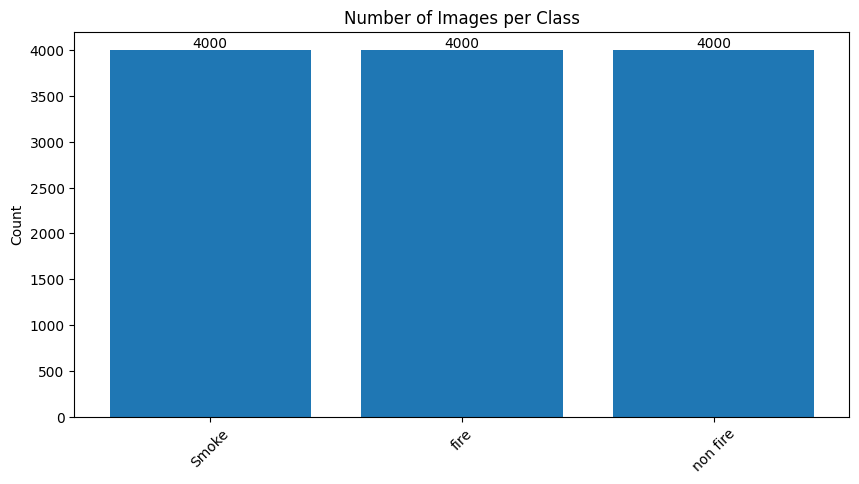

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(labels, values)
ax.set_title("Number of Images per Class")
ax.set_ylabel("Count")
plt.xticks(rotation=45)
ax.bar_label(bars, label_type='edge')

plt.show()

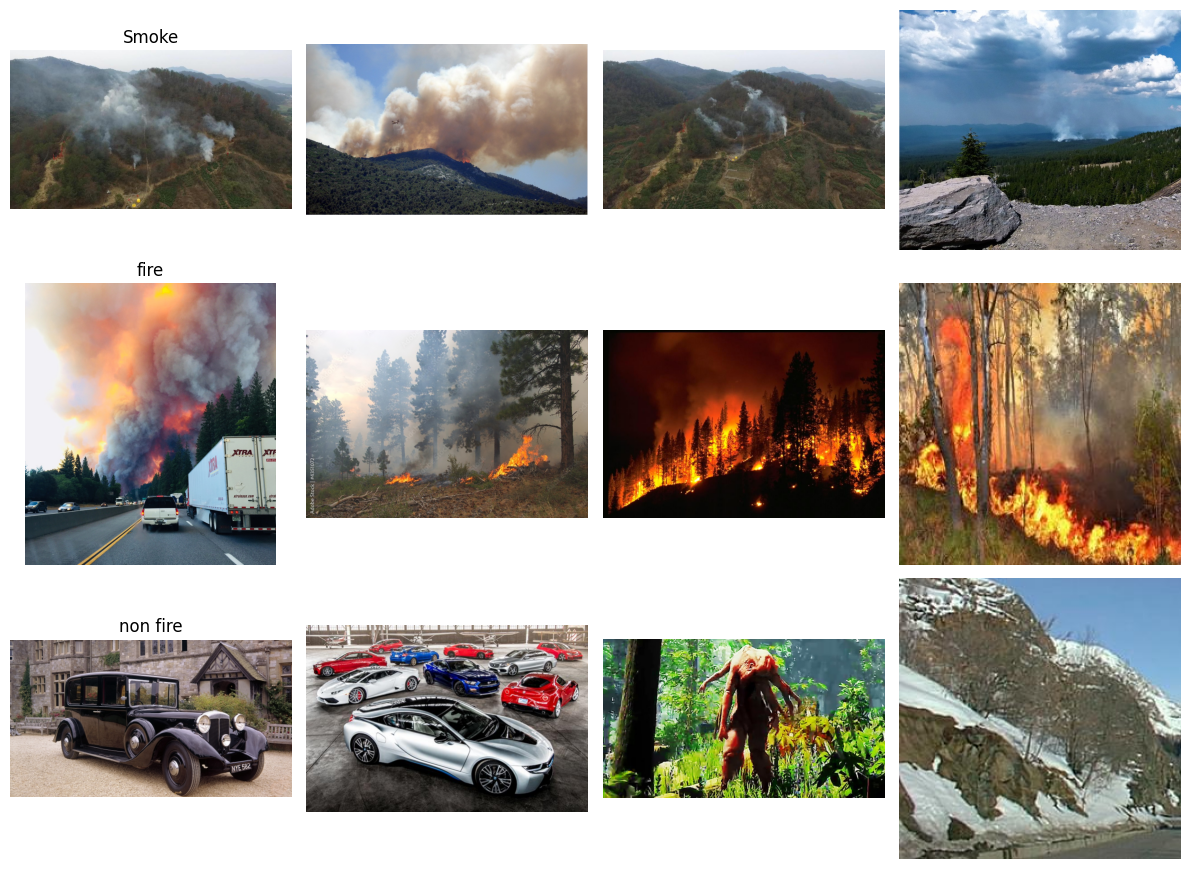

In [30]:
def show_4_per_class(dataset):
    n = 4
    classes = dataset.classes
    plt.figure(figsize=(n * 3, len(classes) * 3))
    counts = {cls: 0 for cls in classes}

    for img, label in dataset:
        cls = classes[label]
        if counts[cls] < n:
            i = classes.index(cls) * n + counts[cls] + 1
            plt.subplot(len(classes), n, i)
            plt.imshow(img)
            plt.axis('off')
            if counts[cls] == 0:
                plt.title(cls)
            counts[cls] += 1

        if all(count >= n for count in counts.values()):
            break

    plt.tight_layout()
    plt.show()

show_4_per_class(raw_train_dataset)

In [31]:
classes = raw_train_dataset.classes

# print size of a few images in each class
for cls in classes:
    class_dir = os.path.join(train_dir, cls)
    images = os.listdir(class_dir)[:3]
    print(f"Class: {cls}")
    for img_name in images:
        img_path = os.path.join(class_dir, img_name)
        with Image.open(img_path) as img:
            print(f"  {img_name} - mode: {img.mode}, size: {img.size}")
    print()

Class: Smoke
  Smoke (7498).jpg - mode: RGB, size: (1920, 1080)
  Smoke (1965).jpg - mode: RGB, size: (1920, 1080)
  Smoke (8714).jpg - mode: RGB, size: (1920, 1080)

Class: fire
  Fire (228).png - mode: RGB, size: (600, 338)
  Fire (7327).jpg - mode: RGB, size: (256, 256)
  Fire (3836).jpg - mode: RGB, size: (299, 168)

Class: non fire
  Non_Fire (9615).jpg - mode: RGB, size: (256, 256)
  Non_Fire (642).jpg - mode: RGB, size: (256, 256)
  Non_Fire (9382).jpg - mode: RGB, size: (256, 256)



All images are different sizes so we want to resize them.

In [32]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [33]:
from sklearn.model_selection import train_test_split
import numpy as np

targets = [label for _, label in raw_train_dataset.imgs]
indices = np.arange(len(raw_train_dataset))

raw_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

train_indices, val_indices = train_test_split(
    indices, test_size=0.2, stratify=targets, random_state=10
)

train_dataset = torch.utils.data.Subset(raw_train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(raw_train_dataset, val_indices)

In [34]:
# Verify image size
img, label = train_dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [35]:
# Verify length of dataset
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 9600
Validation dataset size: 2400


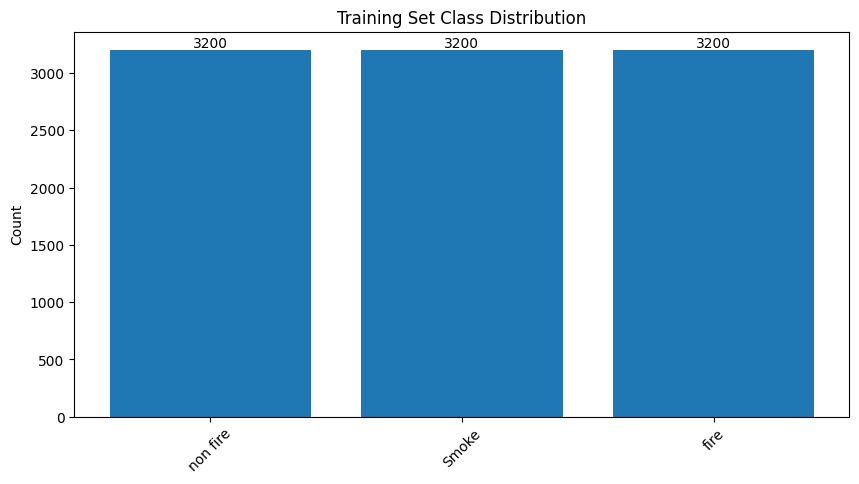

In [36]:
# Train dataset distribution
train_targets = [train_dataset.dataset.targets[i] for i in train_dataset.indices]
train_counts = Counter(train_targets)
train_labels = [train_dataset.dataset.classes[i] for i in train_counts.keys()]
train_values = [train_counts[i] for i in train_counts.keys()]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(train_labels, train_values)
ax.set_title("Training Set Class Distribution")
ax.set_ylabel("Count")
plt.xticks(rotation=45)
ax.bar_label(bars, label_type='edge')
plt.show()

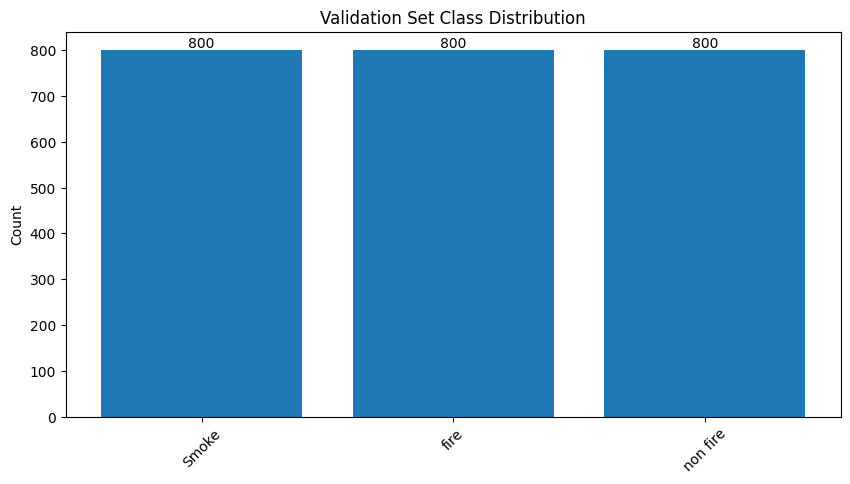

In [37]:
# Validation dataset distribution
val_targets = [val_dataset.dataset.targets[i] for i in val_dataset.indices]
val_counts = Counter(val_targets)
val_labels = [val_dataset.dataset.classes[i] for i in val_counts.keys()]
val_values = [val_counts[i] for i in val_counts.keys()]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(val_labels, val_values)
ax.set_title("Validation Set Class Distribution")
ax.set_ylabel("Count")
plt.xticks(rotation=45)
ax.bar_label(bars, label_type='edge')
plt.show()

In [38]:
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

Models:
- EfficientNet

In [39]:
import torchvision.models as models

In [40]:
class EfficientNetCustom(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = models.efficientnet_b0(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.output = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.output(x)
        return x

In [41]:
num_classes = 3

In [42]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNetCustom(num_classes=num_classes)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [43]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0
    history = {
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Checkpoint the model if validation accuracy improved
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'efficient_net_best.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

    return history

Tune Learning Rate

In [44]:
def make_model(learning_rate=0.01):
    model = EfficientNetCustom(num_classes=num_classes)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [45]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
learning_rate_results = {}

for lr in learning_rates:
    print(f'\n=== Learning Rate: {lr} ===')
    model, optimizer = make_model(learning_rate=lr)
    history = train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, 10, device)
    learning_rate_results[lr] = history


=== Learning Rate: 0.0001 ===
Epoch 1/10
  Train Loss: 0.9434, Train Acc: 0.6249
  Val Loss: 0.7626, Val Acc: 0.8279
Checkpoint saved: efficient_net_best.pth
Epoch 2/10
  Train Loss: 0.6711, Train Acc: 0.8672
  Val Loss: 0.5697, Val Acc: 0.8896
Checkpoint saved: efficient_net_best.pth
Epoch 3/10
  Train Loss: 0.5232, Train Acc: 0.9006
  Val Loss: 0.4606, Val Acc: 0.9062
Checkpoint saved: efficient_net_best.pth
Epoch 4/10
  Train Loss: 0.4346, Train Acc: 0.9109
  Val Loss: 0.3935, Val Acc: 0.9167
Checkpoint saved: efficient_net_best.pth
Epoch 5/10
  Train Loss: 0.3789, Train Acc: 0.9187
  Val Loss: 0.3450, Val Acc: 0.9167
Epoch 6/10
  Train Loss: 0.3370, Train Acc: 0.9283
  Val Loss: 0.3140, Val Acc: 0.9258
Checkpoint saved: efficient_net_best.pth
Epoch 7/10
  Train Loss: 0.3117, Train Acc: 0.9275
  Val Loss: 0.2905, Val Acc: 0.9267
Checkpoint saved: efficient_net_best.pth
Epoch 8/10
  Train Loss: 0.2867, Train Acc: 0.9315
  Val Loss: 0.2714, Val Acc: 0.9279
Checkpoint saved: efficient

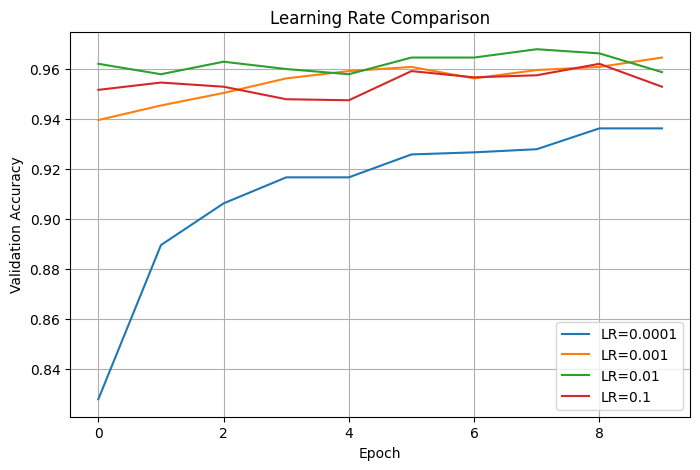

In [46]:
plt.figure(figsize=(8,5))

for lr, hist in learning_rate_results.items():
    plt.plot(hist['val_acc'], label=f'LR={lr}')

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Learning Rate Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
best_learning_rate = 0.01

Add more layers

In [48]:
class EfficientNetCustom(nn.Module):
    def __init__(self, num_classes, size_inner=100):
        super().__init__()
        self.base_model = models.efficientnet_b0(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        self.base_model.classifier = nn.Identity()

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.output = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.output(x)
        return x

In [49]:
inner_sizes = [50, 100, 200, 400]
size_results = {}

for size in inner_sizes:
    print(f'\n=== Inner Size: {size} ===')
    model = EfficientNetCustom(num_classes=num_classes, size_inner=size)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=best_learning_rate)
    history = train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, 10, device)

    size_results[size] = history


=== Inner Size: 50 ===
Epoch 1/10
  Train Loss: 0.2192, Train Acc: 0.9214
  Val Loss: 0.1419, Val Acc: 0.9537
Checkpoint saved: efficient_net_best.pth
Epoch 2/10
  Train Loss: 0.1162, Train Acc: 0.9594
  Val Loss: 0.1039, Val Acc: 0.9679
Checkpoint saved: efficient_net_best.pth
Epoch 3/10
  Train Loss: 0.0925, Train Acc: 0.9670
  Val Loss: 0.0919, Val Acc: 0.9729
Checkpoint saved: efficient_net_best.pth
Epoch 4/10
  Train Loss: 0.0809, Train Acc: 0.9703
  Val Loss: 0.0973, Val Acc: 0.9708
Epoch 5/10
  Train Loss: 0.0795, Train Acc: 0.9699
  Val Loss: 0.1038, Val Acc: 0.9696
Epoch 6/10
  Train Loss: 0.0667, Train Acc: 0.9772
  Val Loss: 0.0870, Val Acc: 0.9704
Epoch 7/10
  Train Loss: 0.0665, Train Acc: 0.9775
  Val Loss: 0.1064, Val Acc: 0.9721
Epoch 8/10
  Train Loss: 0.0590, Train Acc: 0.9797
  Val Loss: 0.1021, Val Acc: 0.9708
Epoch 9/10
  Train Loss: 0.0601, Train Acc: 0.9788
  Val Loss: 0.0867, Val Acc: 0.9717
Epoch 10/10
  Train Loss: 0.0531, Train Acc: 0.9819
  Val Loss: 0.0740

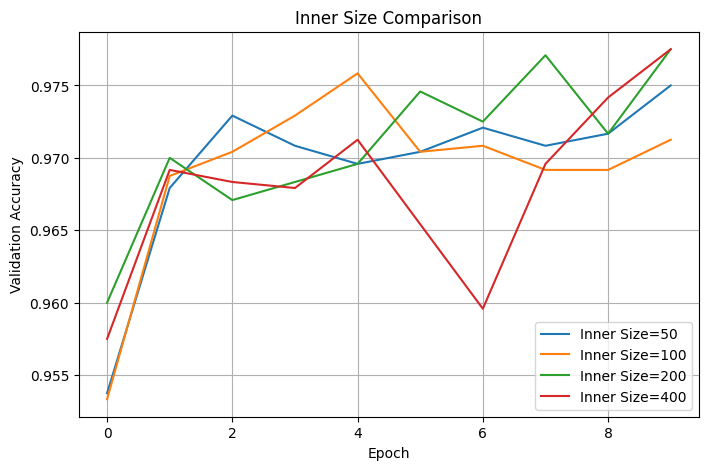

In [50]:
plt.figure(figsize=(8,5))

for size, hist in size_results.items():
    plt.plot(hist['val_acc'], label=f'Inner Size={size}')

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Inner Size Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [54]:
best_size_inner = 200

Add droprate

In [55]:
class EfficientNetCustom(nn.Module):
    def __init__(self, num_classes, size_inner=100, droprate=0.2):
        super(EfficientNetCustom, self).__init__()

        self.base_model = models.efficientnet_b0(weights='IMAGENET1K_V1')

        for param in self.base_model.parameters():
            param.requires_grad = False

        self.base_model.classifier = nn.Identity()

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output(x)
        return x

In [56]:
dropout_rates = [0.0, 0.2, 0.3, 0.4, 0.5]
dropout_results = {}

for droprate in dropout_rates:
    print(f'\n=== Dropout Rate: {droprate} ===')
    model = EfficientNetCustom(num_classes=num_classes, size_inner=best_size_inner, droprate=droprate)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=best_learning_rate)
    history = train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, 10, device)

    # Save val accuracy per epoch in a dict
    dropout_results[droprate] = history


=== Dropout Rate: 0.0 ===
Epoch 1/10
  Train Loss: 0.2305, Train Acc: 0.9125
  Val Loss: 0.1100, Val Acc: 0.9667
Checkpoint saved: efficient_net_best.pth
Epoch 2/10
  Train Loss: 0.1054, Train Acc: 0.9641
  Val Loss: 0.0985, Val Acc: 0.9717
Checkpoint saved: efficient_net_best.pth
Epoch 3/10
  Train Loss: 0.0881, Train Acc: 0.9702
  Val Loss: 0.0950, Val Acc: 0.9679
Epoch 4/10
  Train Loss: 0.0763, Train Acc: 0.9724
  Val Loss: 0.0946, Val Acc: 0.9692
Epoch 5/10
  Train Loss: 0.0681, Train Acc: 0.9754
  Val Loss: 0.1024, Val Acc: 0.9679
Epoch 6/10
  Train Loss: 0.0527, Train Acc: 0.9826
  Val Loss: 0.1010, Val Acc: 0.9683
Epoch 7/10
  Train Loss: 0.0547, Train Acc: 0.9791
  Val Loss: 0.0882, Val Acc: 0.9717
Epoch 8/10
  Train Loss: 0.0500, Train Acc: 0.9830
  Val Loss: 0.0831, Val Acc: 0.9729
Checkpoint saved: efficient_net_best.pth
Epoch 9/10
  Train Loss: 0.0508, Train Acc: 0.9818
  Val Loss: 0.0979, Val Acc: 0.9717
Epoch 10/10
  Train Loss: 0.0473, Train Acc: 0.9834
  Val Loss: 0.1

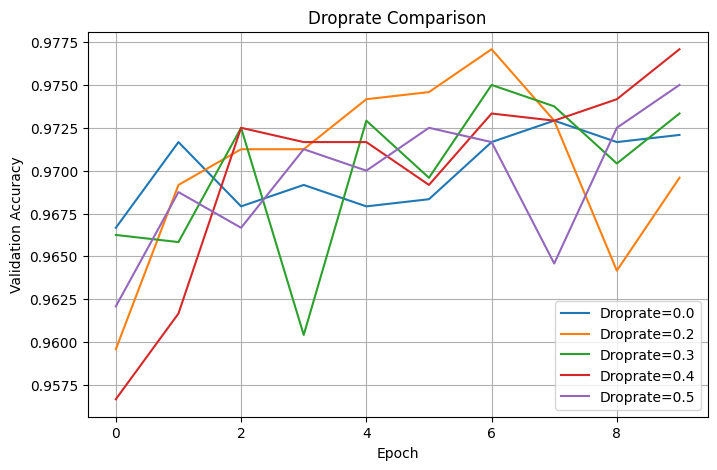

In [57]:
plt.figure(figsize=(8,5))

for dropout, hist in dropout_results.items():
    plt.plot(hist['val_acc'], label=f'Droprate={dropout}')

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Droprate Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [58]:
best_droprate = 0.4

Test accuracy: 97.15%

In [59]:
!zip -r train_small.zip images/train_small

Streaming output truncated to the last 5000 lines.
  adding: images/train_small/Smoke/Smoke (6220).jpg (deflated 2%)
  adding: images/train_small/Smoke/Smoke (155).jpeg (deflated 2%)
  adding: images/train_small/Smoke/Smoke (5671).jpg (deflated 1%)
  adding: images/train_small/Smoke/Smoke (3808).jpg (deflated 0%)
  adding: images/train_small/Smoke/Smoke (6118).jpg (deflated 2%)
  adding: images/train_small/Smoke/Smoke (365).jpeg (deflated 2%)
  adding: images/train_small/Smoke/Smoke (3052).jpg (deflated 12%)
  adding: images/train_small/Smoke/Smoke (562).tif (deflated 22%)
  adding: images/train_small/Smoke/Smoke (2808).jpg (deflated 0%)
  adding: images/train_small/Smoke/Smoke (551).jpg (deflated 1%)
  adding: images/train_small/Smoke/Smoke (8532).jpg (deflated 1%)
  adding: images/train_small/Smoke/Smoke (8116).jpg (deflated 1%)
  adding: images/train_small/Smoke/Smoke (2217).jpg (deflated 5%)
  adding: images/train_small/Smoke/Smoke (6058).jpg (deflated 2%)
  adding: images/train_sm

In [60]:
from google.colab import files
files.download("train_small.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>